In [1]:
import networkx as nx
import itertools
import matplotlib.pyplot as plt

In [2]:
file_path = "toy_network.txt"

In [3]:
G = nx.read_weighted_edgelist(file_path, nodetype=int, create_using=nx.Graph())
charger_nodes = [2, 4, 7, 9]

In [4]:
def is_subpath(subpath, path):
    n = len(subpath)
    m = len(path)
    for i in range(m - n + 1):
        if path[i:i + n] == subpath:
            return True
    return False

In [5]:
def remove_subpaths(paths, distances):
    new_paths = []
    new_distances = []

    for i in range(len(paths)):
        add_path = True
        for j in range(len(paths)):
            if i != j and is_subpath(paths[i], paths[j]):
                add_path = False
                break
        if add_path:
            new_paths.append(paths[i])
            new_distances.append(distances[i])
    return new_paths, new_distances

In [6]:
def merge_arrays(arr1, arr2, dist1, dist2):
    if not arr1 or not arr2:
        return [], 0.0

    merged_array = arr1 + arr2[1:]
    merged_distance = dist1 + dist2

    return merged_array, merged_distance

In [7]:
def recursive_merging(input_array, input_distances):
    global merged_array_repo
    merged_array = []
    combined_listing = list(itertools.combinations(input_array, 2))
    combined_array = [list(combination) for combination in combined_listing]

    to_remove = []

    counter = 0
    for comb in combined_array:
        if comb[0][-1] == comb[1][0]:
            counter += 1

    if counter == 0:
        return merged_array_repo, distance_repo

    for comb in combined_array:
        if comb[0][-1] == comb[1][0]:
            merged_array, merged_distance = merge_arrays(
                comb[0], comb[1:][0], input_distances[input_array.index(comb[0])], input_distances[input_array.index(comb[1:][0])]
            )
            merged_array_repo.append(merged_array)
            distance_repo.append(merged_distance)
            to_remove.extend([comb[0], comb[1:][0]])

    merged_array_repo = [sublist for sublist in merged_array_repo if sublist not in to_remove]

    return recursive_merging(merged_array_repo, distance_repo)

In [8]:
def evchargepath(OD_nodes, distance_range, charger_nodes, G):

    naive_shortest_distance = nx.shortest_path_length(G, source=OD_nodes[0], target=OD_nodes[1], weight='weight')
    if naive_shortest_distance <= distance_range:
        naive_shortest_path = nx.shortest_path(G, source=OD_nodes[0], target=OD_nodes[1], weight='weight')
        return naive_shortest_path, naive_shortest_distance
    else:
        concerned_nodes = sorted(OD_nodes + charger_nodes)
        node_combinations = list(itertools.combinations(concerned_nodes, 2))
        sh_path_ranged = []
        sh_path_dist_ranged = []
        for s, t in node_combinations:
            shortest_distance = nx.shortest_path_length(G, source=s, target=t, weight='weight')
        
            if shortest_distance <= distance_range:
                shortest_path = nx.shortest_path(G, source=s, target=t, weight='weight')
                if OD_nodes[1] in shortest_path and shortest_path.index(OD_nodes[1]) == len(shortest_path) - 1:
                    sh_path_ranged.append(shortest_path)
                    sh_path_dist_ranged.append(shortest_distance)
                elif OD_nodes[1] not in shortest_path:
                    sh_path_ranged.append(shortest_path)
                    sh_path_dist_ranged.append(shortest_distance)
        
        sh_path_ranged, sh_path_dist_ranged = remove_subpaths(sh_path_ranged, sh_path_dist_ranged)
        global merged_array_repo
        global distance_repo
        merged_array_repo = []
        distance_repo = []
        
        list_of_paths, list_of_distances = recursive_merging(sh_path_ranged, sh_path_dist_ranged)
        valid_paths = []
        valid_distances = []
        for each_path, each_distance in zip(list_of_paths, list_of_distances):
            if each_path[0] == OD_nodes[0] and each_path[-1] == OD_nodes[1]:
                valid_paths.append(each_path)
                valid_distances.append(each_distance)
        if distance_repo:
            min_distance_index = distance_repo.index(min(distance_repo))
        
            # Retrieve the corresponding path from list_of_paths
            shortest_path = list_of_paths[min_distance_index]
            shortest_distance = list_of_distances[min_distance_index]
            return shortest_path, shortest_distance
            #print(f"\nShortest Path: {shortest_path}, Shortest Distance: {shortest_distance}")
            
        else:
            print("\nNo valid paths found.")

Origin :  0
Destination :  1


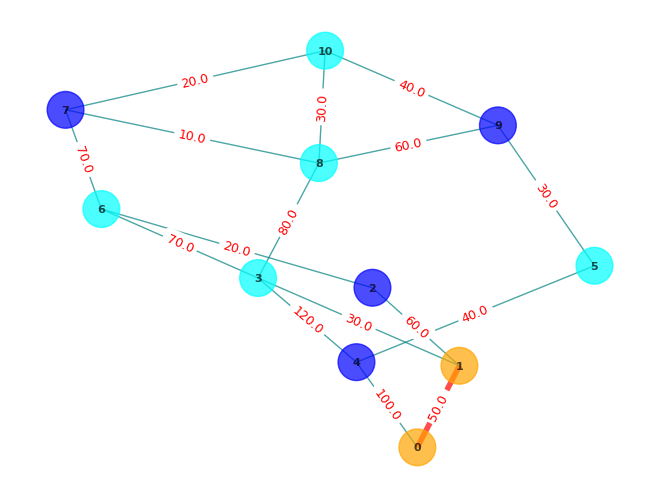

Origin :  0
Destination :  3


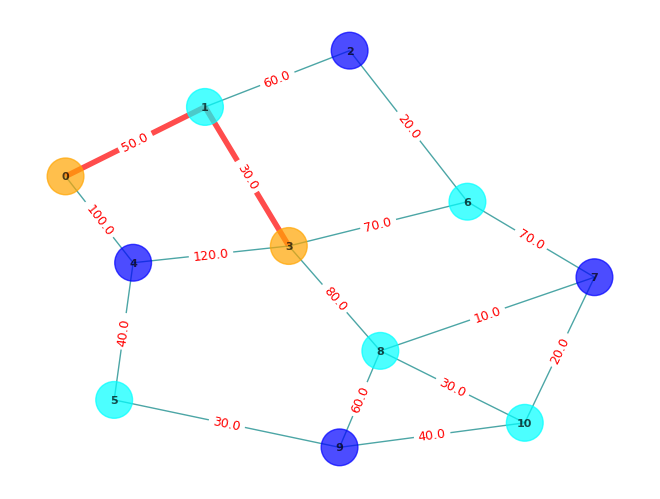

Origin :  1
Destination :  5


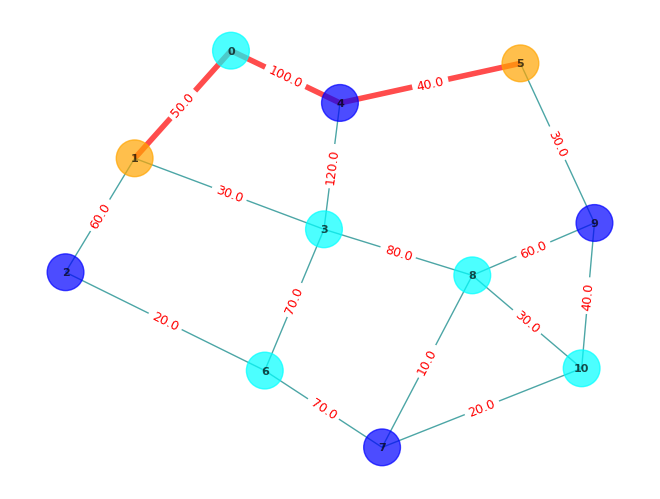

Origin :  1
Destination :  3


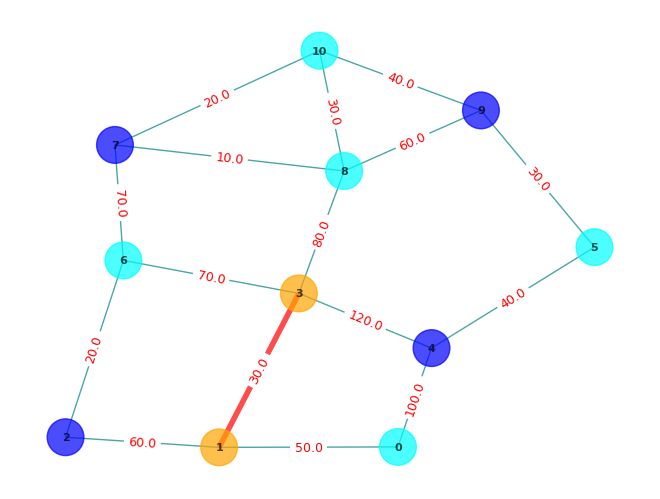

Origin :  0
Destination :  5


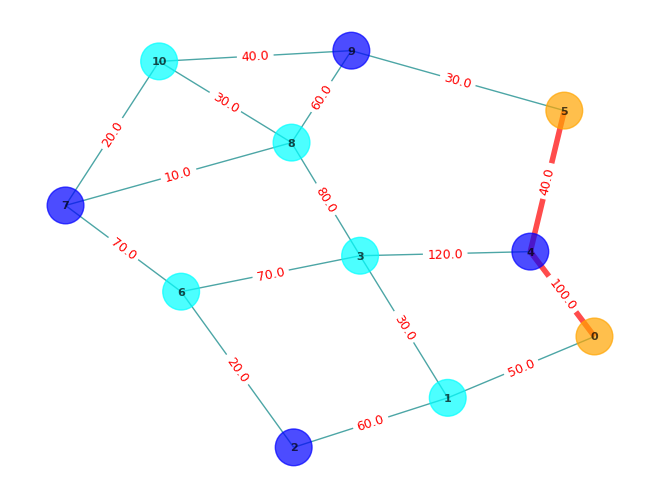

Origin :  1
Destination :  6


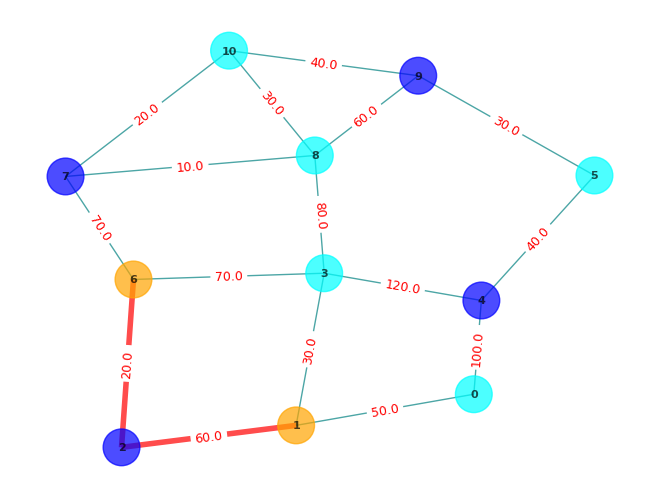

Origin :  1
Destination :  8


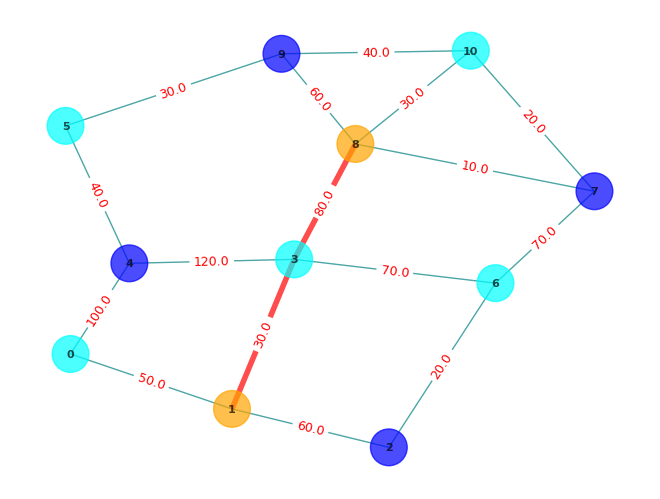

Origin :  1
Destination :  10


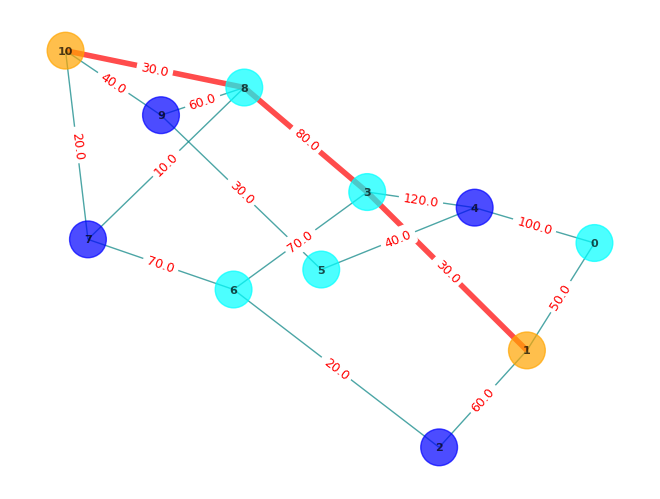

Origin :  3
Destination :  5


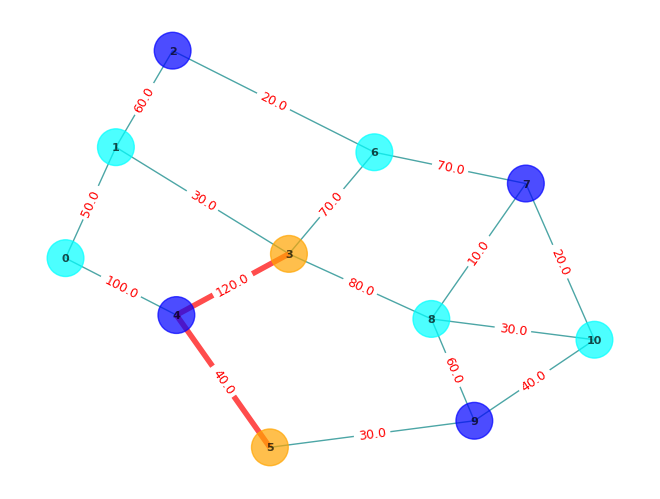

Origin :  1
Destination :  6


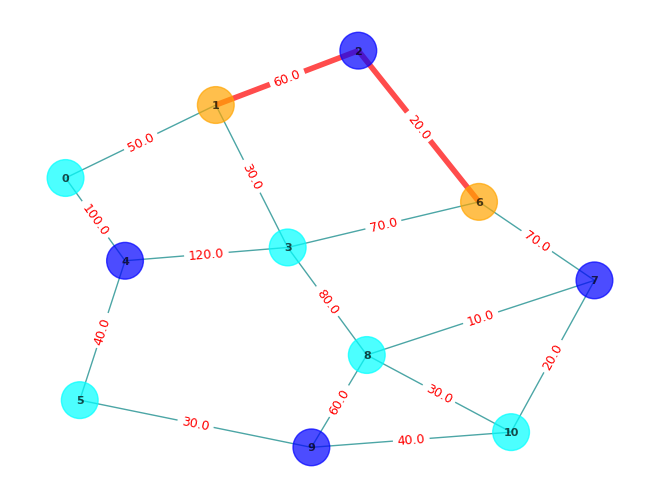

Origin :  1
Destination :  8


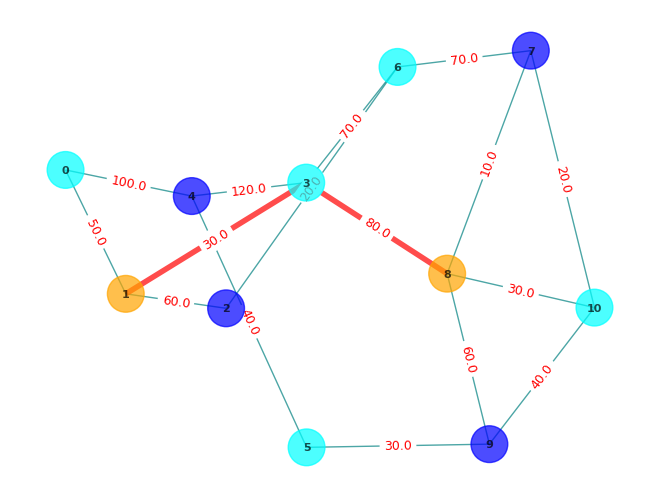

Origin :  1
Destination :  10


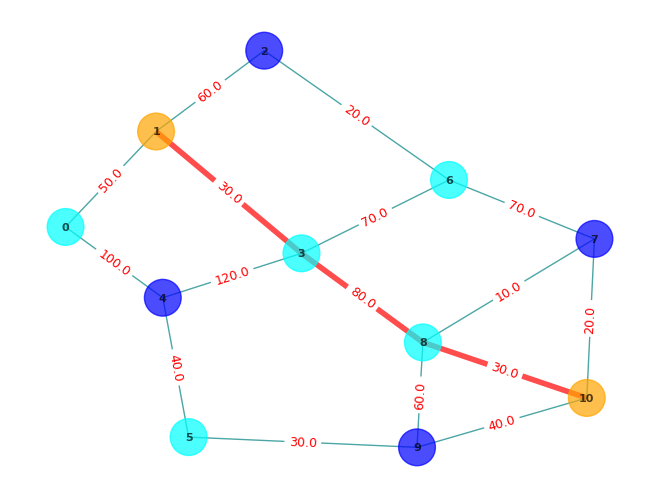

Origin :  5
Destination :  6


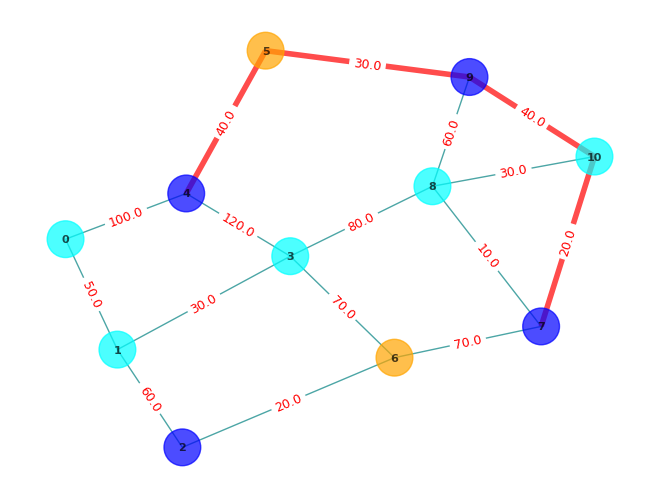

Origin :  5
Destination :  8


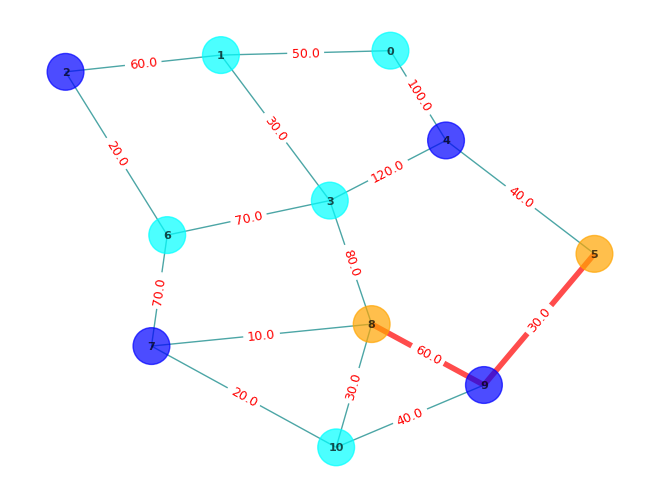

Origin :  1
Destination :  10


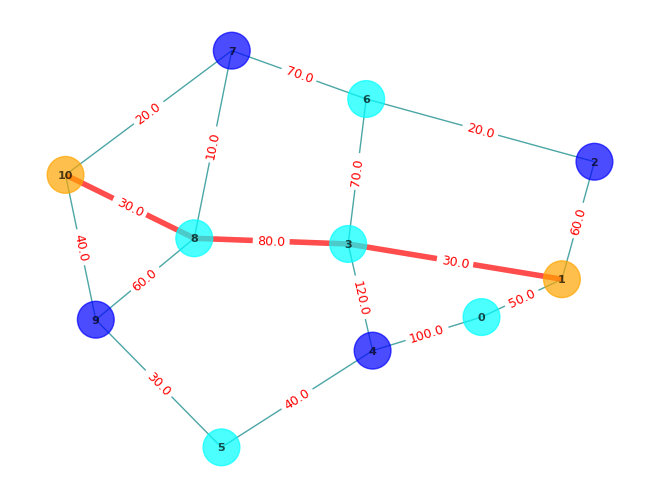

Origin :  6
Destination :  8


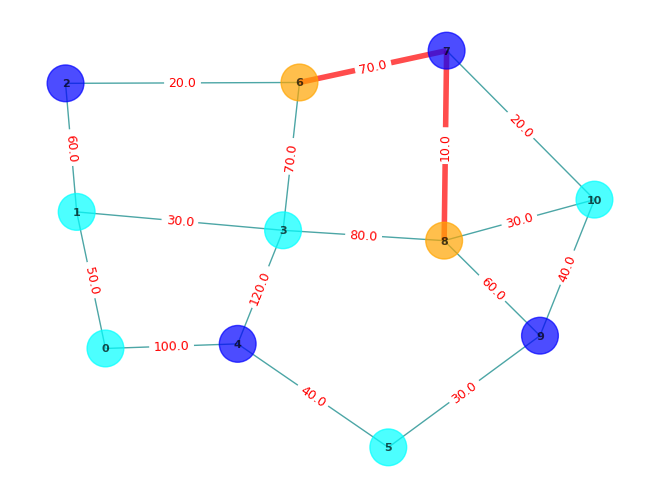

Origin :  1
Destination :  10


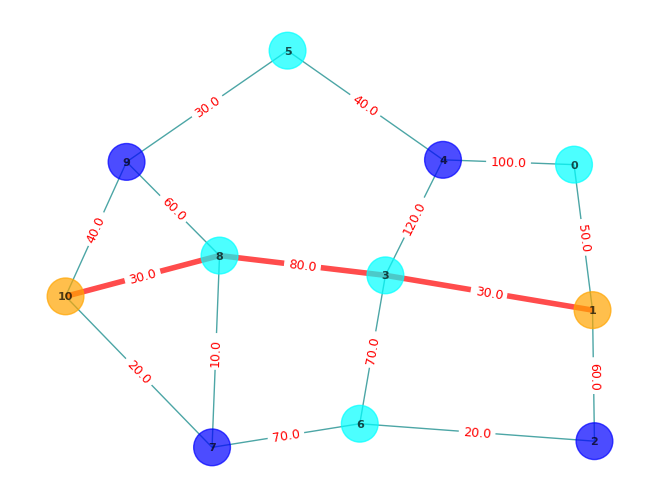

Origin :  8
Destination :  10


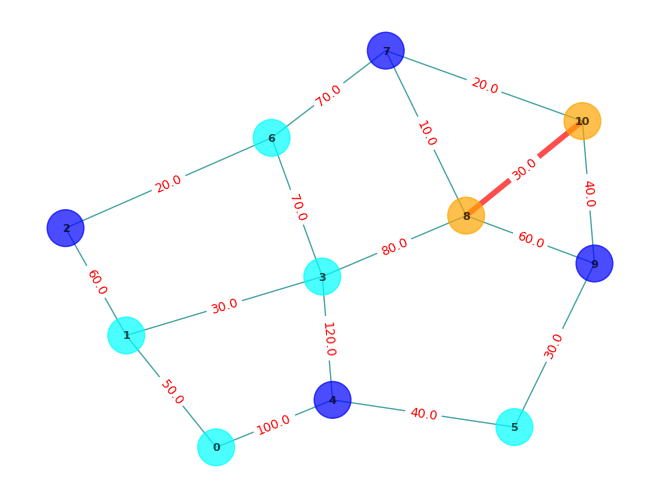

In [10]:
OD_nodes = [0,10]
distance_range = 150.0
charger_nodes = [2, 4, 7, 9]
for i in range(G.number_of_nodes()):
    for j in range(G.number_of_nodes()):
        if i<j and i not in charger_nodes and j not in charger_nodes:
            OD_nodes[0] = i
            OD_nodes[1] = j
            print("Origin : ", OD_nodes[0])
            print("Destination : ",OD_nodes[1])
            shortest_path, shortest_distance = evchargepath(OD_nodes, distance_range, charger_nodes, G)

            H = G.copy()
            
            node_colors = []
            for node in G.nodes():
                if node in OD_nodes:
                    node_colors.append('orange')
                elif node in charger_nodes:
                    node_colors.append('blue')
                else:
                    node_colors.append('cyan')
            
            for i in range(len(shortest_path) - 1):
                H[shortest_path[i]][shortest_path[i+1]]['width'] = 4.0
                H[shortest_path[i]][shortest_path[i+1]]['color'] = 'red'
            
            edge_width = [H[u][v].get('width', 1.0) for u, v in H.edges()]
            edge_colors = [H[u][v].get('color', 'teal') for u, v in H.edges()]
            
            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels = True, font_weight = 'bold' , node_size = 700 , node_color=node_colors, font_size=8, font_color='black', edge_color=edge_colors, width=edge_width, alpha=0.7)
            
            edge_labels = nx.get_edge_attributes(G, 'weight')
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=9)
            
            plt.show()